In [2]:
# %pip install torch torchvision
# %pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3537k  100 3537k    0     0  10.8M      0 --:--:-- --:--:-- --:--:-- 10.8M


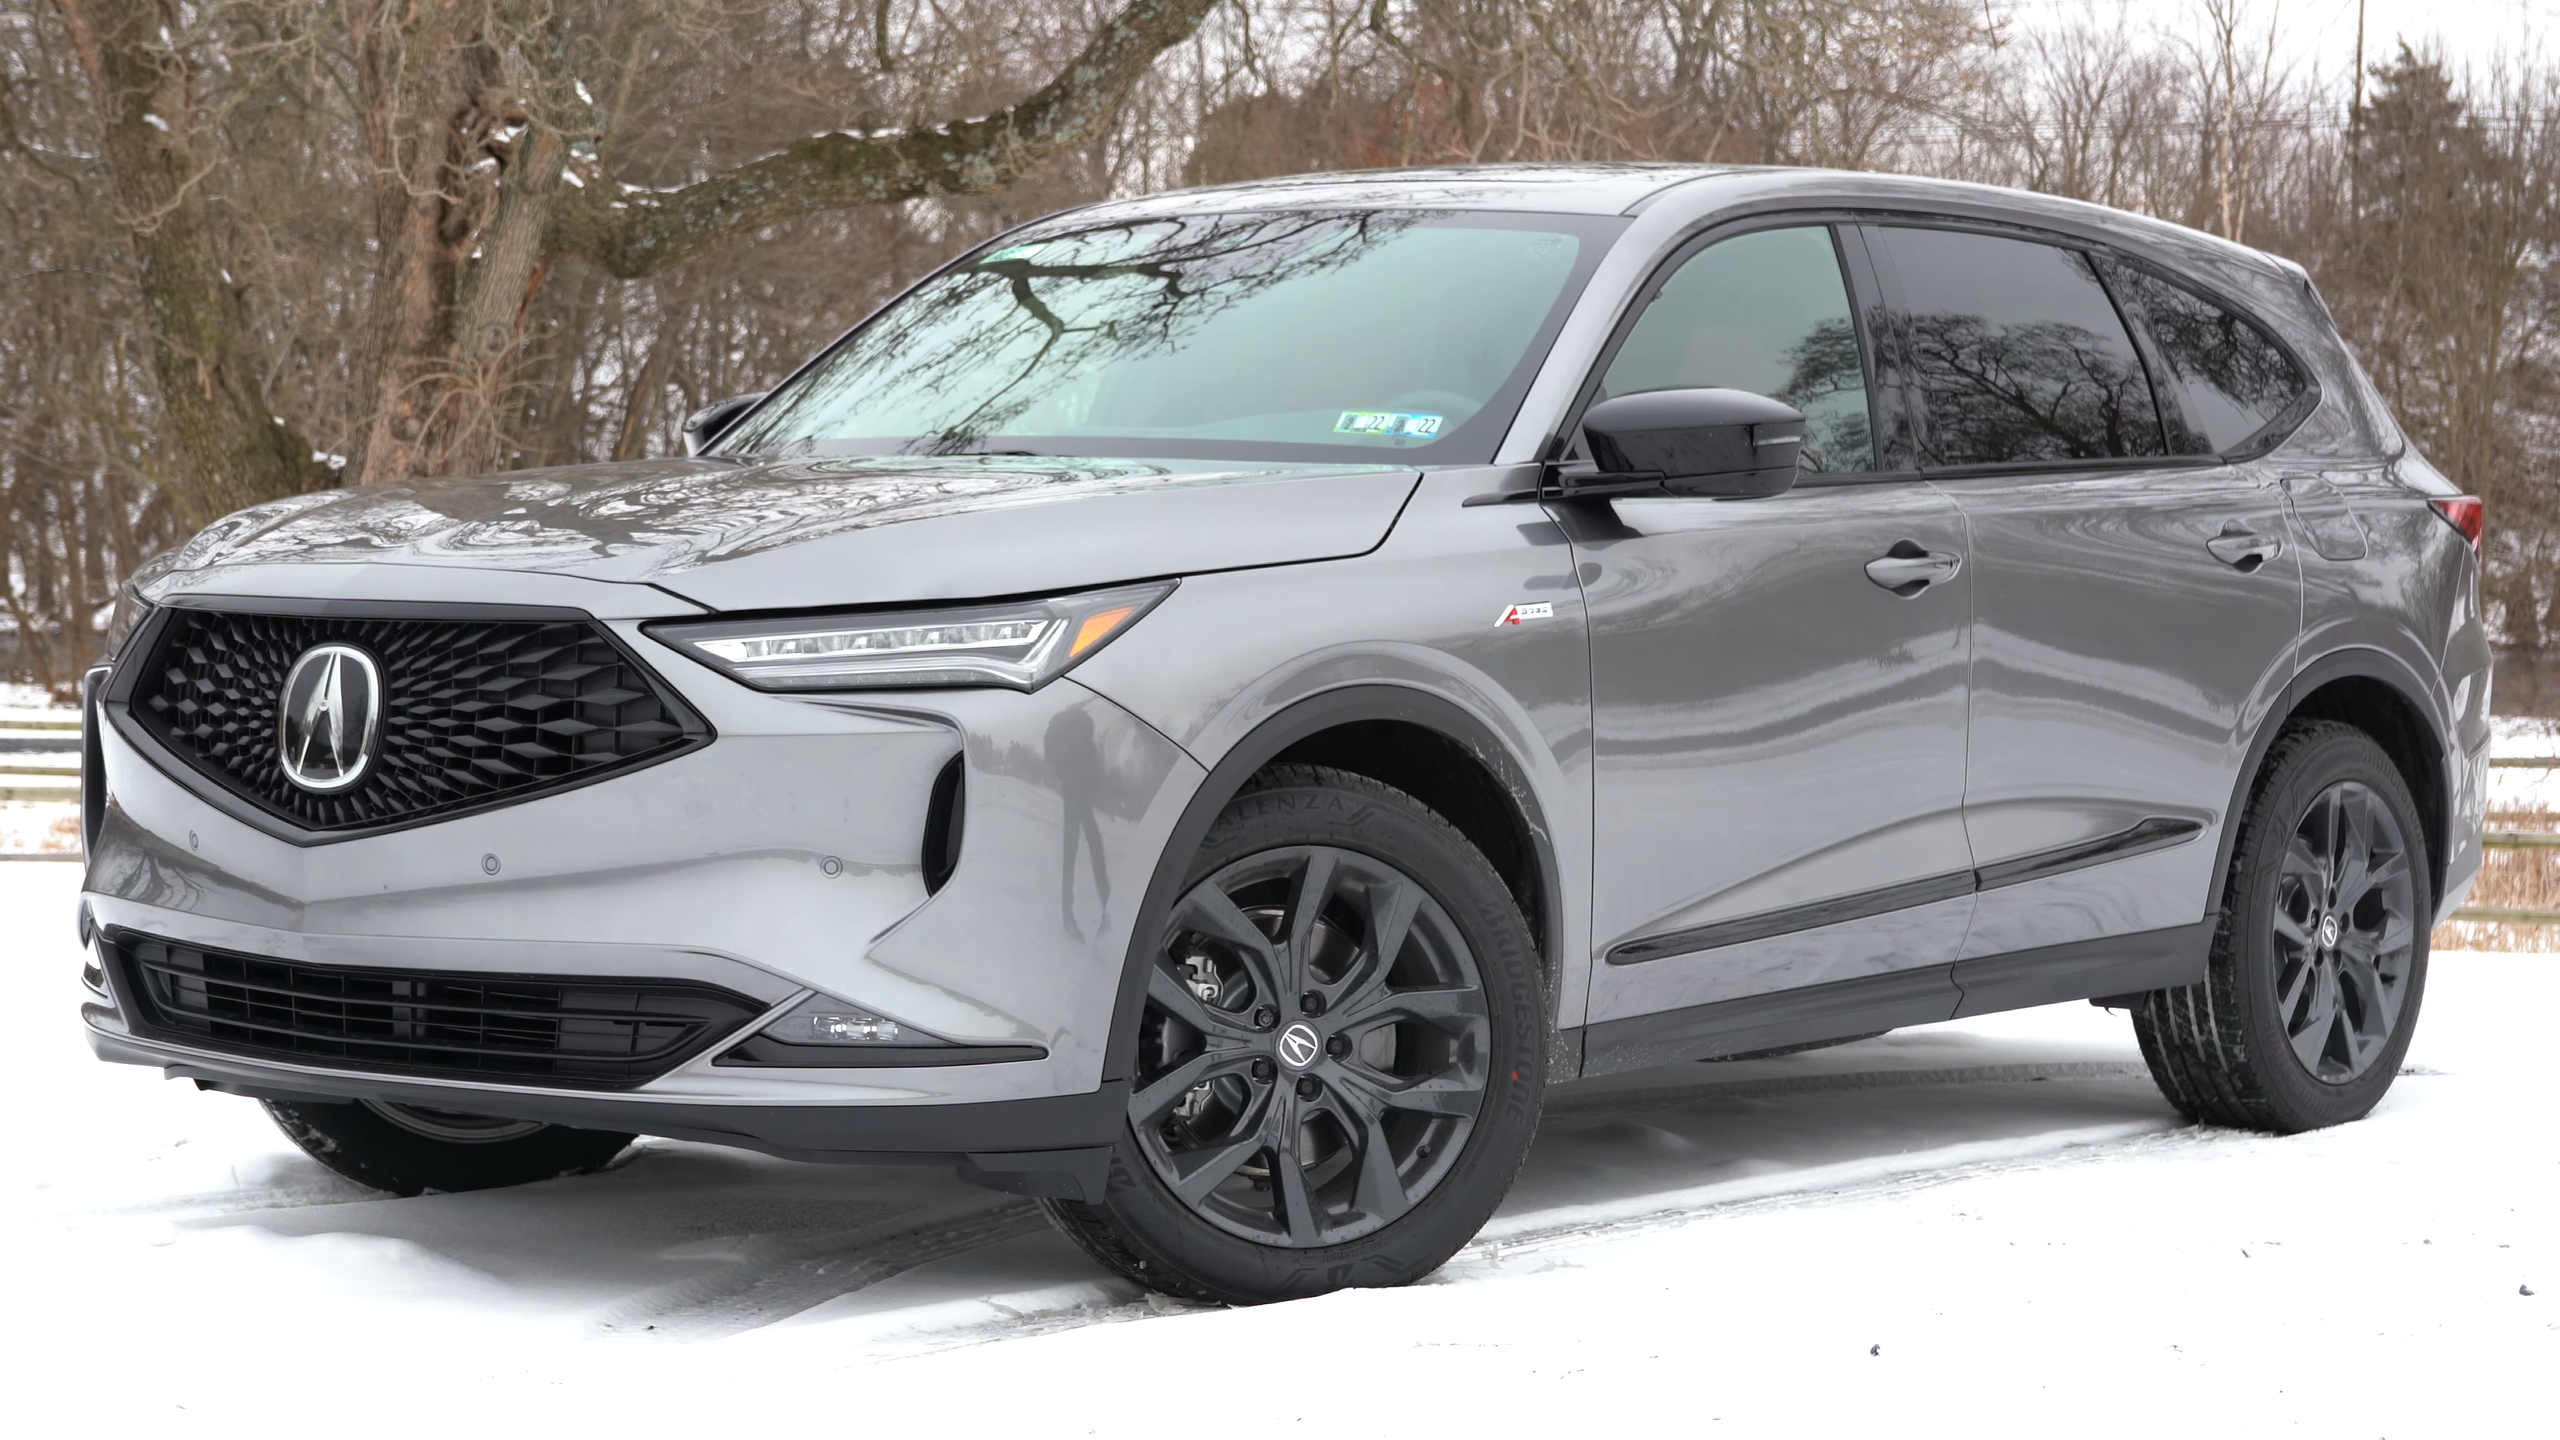

In [3]:
!curl "https://upload.wikimedia.org/wikipedia/commons/thumb/6/66/2022_Acura_MDX_%28United_States%29_front_view_01.png/2560px-2022_Acura_MDX_%28United_States%29_front_view_01.png" -o car.png

from PIL import Image
image_pil = Image.open("car.png").convert("RGB")
image_pil

In [30]:
%%time
from lang_sam import LangSAM

model = LangSAM()

text_prompt = "wheel"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

final text_encoder_type: bert-base-uncased
Model loaded from /home/ec2-user/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
CPU times: user 51.5 s, sys: 2.63 s, total: 54.2 s
Wall time: 6.9 s


In [5]:
%pip install -U ezsmdeploy==2.0.6

  Obtaining dependency information for ezsmdeploy==2.0.6.dev3 from https://files.pythonhosted.org/packages/b5/b1/44e7b4961ab61966b3a84939736876f9e49fe8667e69ff07b79382dbc405/ezsmdeploy-2.0.6.dev3-py3-none-any.whl.metadata
  Attempting uninstall: ezsmdeploy
    Found existing installation: ezsmdeploy 2.0.5
    Uninstalling ezsmdeploy-2.0.5:
      Successfully uninstalled ezsmdeploy-2.0.5
Note: you may need to restart the kernel to use updated packages.


In [46]:
%%writefile langsam_inference.py

import os
import json
import base64
from PIL import Image
from lang_sam import LangSAM
import torch
torch.cuda.empty_cache() 

import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=16'

def load_model(modelpath):
    model = LangSAM()
    print("Loaded LangSAM successfully")

    return model

# return prediction based on loaded model (from the step above) and an input payload
def predict(model, payload):
    
    
    # json_payload = '{"size": [100, 100], "image_bytes": "BASE64_ENCODED_IMAGE_DATA", "text_prompt": "wheel"}'

    # Parse the JSON payload
    payload = json.loads(payload)

    # Decode the Base64 image data back into bytes
    image_bytes_base64 = payload['image_bytes']
    image_bytes = base64.b64decode(image_bytes_base64)
    
    size = payload['size']
    text_prompt = payload['text_prompt']
    
    image_pil = Image.frombytes("RGB",size = size, data = image_bytes) 
    
    masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)
    
    return json.dumps({'boxes':boxes.tolist()})

Overwriting langsam_inference.py


In [47]:
import ezsmdeploy

In [48]:
!touch dummy.model #this is required since we are downloading a model from the hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
requirements = ['torch==2.0.1',
                'torchvision==0.15.2'
               ]

In [50]:
# !sm-docker build . --file ./src/Dockerfile

In [51]:
ezonsm = ezsmdeploy.Deploy(model = 'dummy.model',
                           script='langsam_inference.py',
                           requirements=requirements,
                           dockerextras=['RUN pip3 install -U git+https://github.com/luca-medeiros/lang-segment-anything.git'],
                           instance_type='ml.r5.4xlarge',
                           volume_size=500,
                           wait_time=1200
                          )

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
0:00:00.002206 | compressed model(s)
0:00:00.034510 | uploaded model tarball(s) ; check returned modelpath
0:00:00.034970 | added requirements file
0:00:00.035932 | added source file
0:00:00.036631 | added Dockerfile
0:00:00.037638 | added model_handler and docker utils
0:00:00.037683 | building docker container
added Docker extras into docker file
∙∙● 

WARNING! Your password will be stored unencrypted in /root/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



0:05:16.010255 | built docker container
∙●∙ sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
∙∙● sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
0:05:16.186514 | created model(s). Now deploying on ml.r5.4xlarge
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
0:11:48.949675 | deployed model
0:11:48.949740 | Done! ✔ 


In [53]:
# Dockerfile is saved in src. To test or build locally, do:
# !src/build-docker.sh test

In [97]:
import json
import base64

# Try changing the text prompt to wheel, car, logo, headlight
payload = {'size':image_pil.size,
           'image_bytes':base64.b64encode(image_pil.tobytes()).decode(),
           'text_prompt':'wheel'}

In [105]:
%%time
response = ezonsm.predict(json.dumps(payload))

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint ezsm-endpoint-hjptqvlejwey5pz8xnmpm5 of account 716845917484 not found.

In [99]:
response

b'{"boxes": [[1034.93212890625, 762.7972412109375, 1550.3443603515625, 1296.9617919921875], [2130.7490234375, 715.986572265625, 2436.1494140625, 1133.1729736328125], [256.2049865722656, 1094.8978271484375, 637.5927124023438, 1196.456787109375]]}'

In [100]:
boxes = json.loads(response)['boxes']

In [101]:
from PIL import Image, ImageDraw

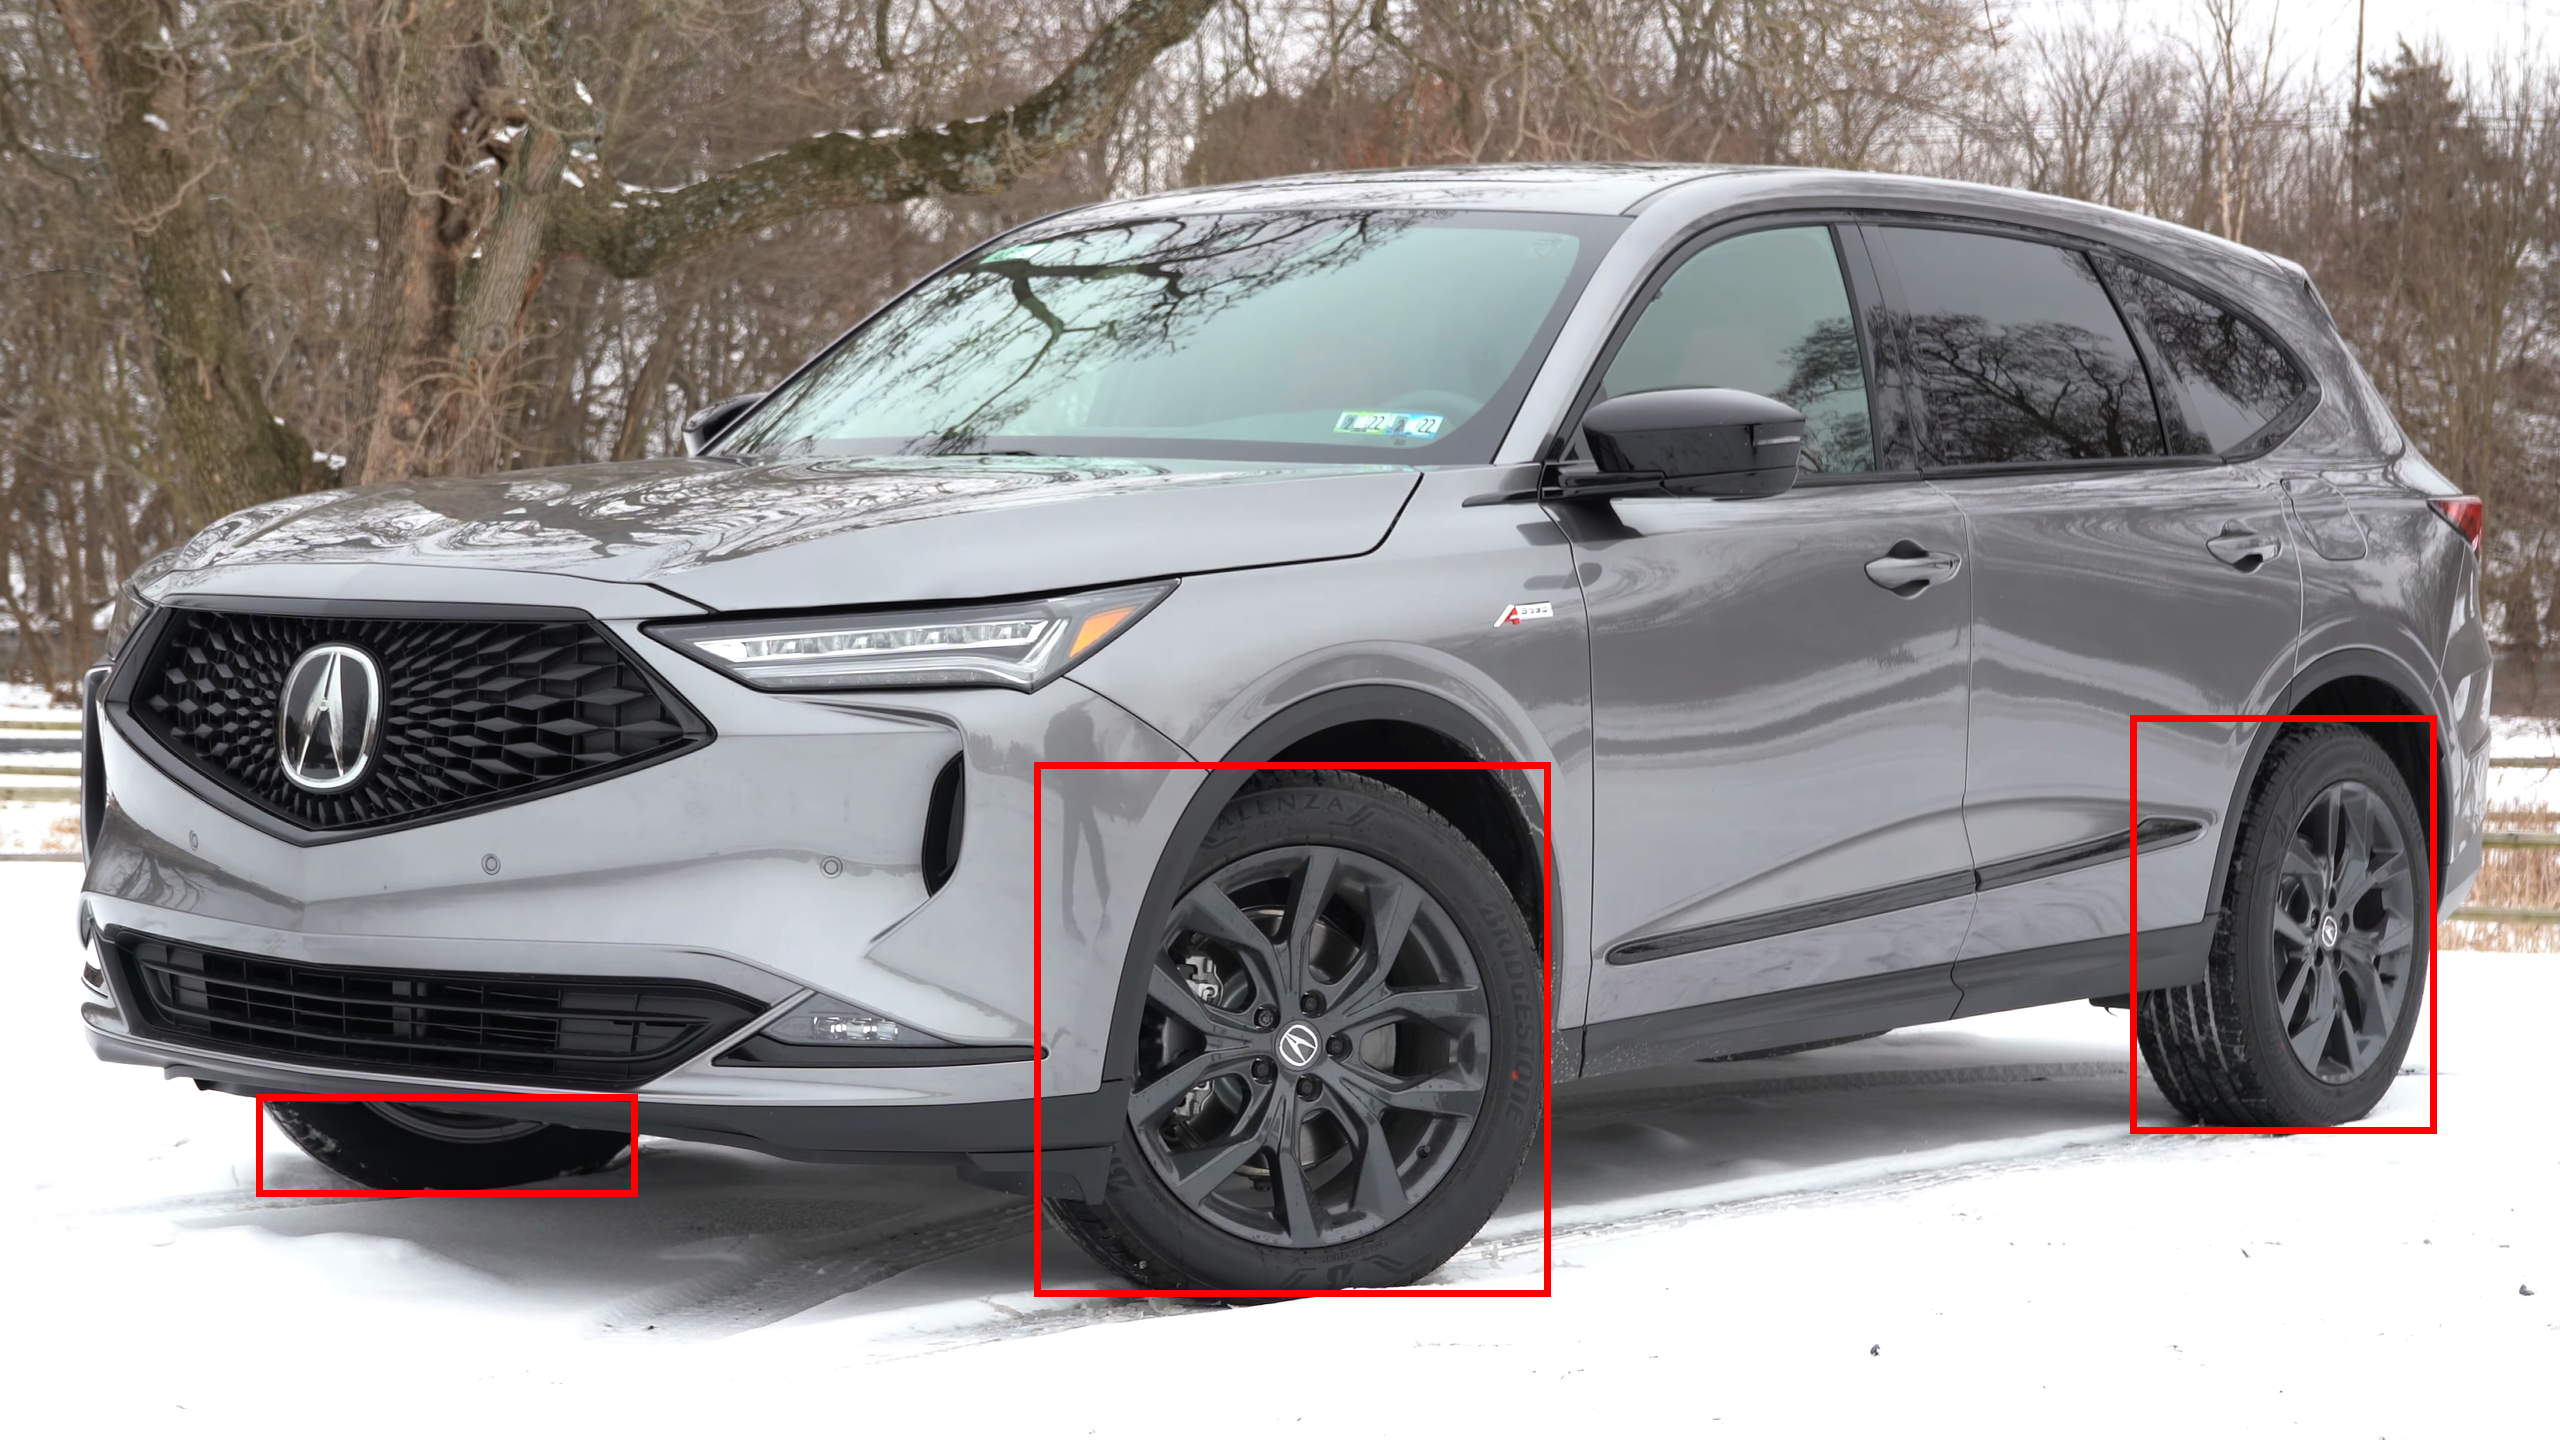

In [102]:
image_pil = Image.open("car.png").convert("RGB")
drawable_image = ImageDraw.Draw(image_pil)

# Draw each bounding box
for box in boxes:
    drawable_image.rectangle(box, outline="red", width=7)

# Display the image
image_pil.show()

In [103]:
ezonsm.delete_endpoint()